# One-Dimensional Laminar Premixed Flames: Chemical Mechanisms

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 8 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 19 February 2020.

The objective of this tutorial is to compare laminar flame speeds and flame structures computed using a realistic reaction mechanism with those obtained using a highly reduced global mechanism. We will use the thermodynamic properties, reaction mechanism, and molecular transport properties that are included in CERFACS_2step_propane.cti and Peters_C3H8.cti.

The files "CERFACS_2step_propane.cti" (used earlier in tutorial Notebook 5_1_Global_reactions) and "Peters_C3H8.cti" (both are provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti files are also available at https://www.cerfacs.fr/cantera/mechanisms/prop.php.

The reader should be familiar with the material in the previous tutorial Notebook (8_1_Steady_1D_laminar_premixed_flame) before working through this Notebook.

## 1. Motivation and scope

In the previous tutorial Notebook (8_1_Steady_1D_laminar_premixed_flame), we looked at how to set up and solve for the laminar flame speed and flame structure using Cantera. As discussed there and in Chapter 8 of Turns 4th ed., the flame speed is determined by a balance between chemical reaction rates and molecular transport. In this Notebook, we look at the influence of the reaction mechanism by comparing results from a realistic multistep reaction mechanism with those from a highly reduced global mechanism, for the same molecular transport model. In the next Notebook, we will look at the influence of using different molecular transport models, for the same reaction mechanism.

In general, the motivation for using a reduced reaction mechanism in numerical studies is to reduce the computational time required. That is not much of an issue when computing a single flame, but it becomes more important when we need to simulate large numbers of flames over a wide range of conditions, and eventually go beyond steady one-dimensional laminar flames. The reduced computational time for a smaller mechanism is usually at the expense of accuracy and/or generality. In general, the more highly reduced a mechanism is, the narrower the range of thermochemical conditions (pressure, temperature, and equivalence ratio) over which it can be expected to give reasonable results.

Here we consider propane-air reactant mixtures, and two chemical mechanisms: a global two-step mechanism (CERFACS_2step_propane.cti) that we have used before, and a relatively more detailed mechanism (Peters_C3H8.cti), both of which are provided with this Notebook and are available at https://www.cerfacs.fr/cantera/mechanisms/prop.php. The range of conditions over which these mechanisms are intended to be used can be found there. In general, the two-step mechanism gives flame speeds that are in reasonable agreement with those from the more detailed mechanism for fuel-lean-to-stoichiometric reactants. For fuel-rich reactants, the flame speeds from the two-step mechanism are unrealistically high, as will be seen below.

## 2. Flame speed and flame structure for stoichiometric reactants

We'll start by defining gas mixtures based on the two reaction mechanisms, and considering a stoichiometric fuel-air reactant mixture at ambient temperature and pressure.

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define two gas mixtures using two different reaction mechanisms
# see the comments and content of each .cti file for more information
gas1 = ct.Solution('data/CERFACS_2step_propane.cti')
gas2 = ct.Solution('data/Peters_C3H8.cti')

Compare the numbers of species and numbers of reactions used in the two mechanisms, and the transport model that will be used with each.

In [3]:
# print the number of species in each reaction mechanism
gas1.n_species , gas2.n_species

(6, 31)

In [4]:
# print the number of reactions in each reaction mechanism
gas1.n_reactions , gas2.n_reactions

(2, 107)

In [5]:
# print the transport model associated with each reaction mechanism
gas1.transport_model , gas2.transport_model

('Mix', 'Mix')

The larger mechanism has approximately five times the number of species and 50 times the number of reactions of the smaller mechanism. A mixture-averaged transport model is used, in both cases. For future reference, we print the species considered in both mechanisms:

In [6]:
# print the species considered in gas1
gas1.species()

[<Species CO>,
 <Species C3H8>,
 <Species CO2>,
 <Species H2O>,
 <Species N2>,
 <Species O2>]

In [7]:
# print the species considered in gas2
gas2.species()

[<Species C3H8>,
 <Species C3H3>,
 <Species O>,
 <Species H>,
 <Species OH>,
 <Species CO>,
 <Species H2>,
 <Species O2>,
 <Species H2O>,
 <Species HO2>,
 <Species H2O2>,
 <Species CH>,
 <Species CH2>,
 <Species CH3>,
 <Species CH4>,
 <Species C2H>,
 <Species C2H2>,
 <Species C2H3>,
 <Species C2H4>,
 <Species C2H5>,
 <Species C2H6>,
 <Species C3H6>,
 <Species I*C3H7>,
 <Species N*C3H7>,
 <Species CO2>,
 <Species HCO>,
 <Species CH2O>,
 <Species C2HO>,
 <Species C3H4>,
 <Species C3H5>,
 <Species N2>]

By comparing the two lists, it can be seen that all of the six species considered in gas1 are also included in gas2, and that the same species names are used for these six species, in both cases.

In [8]:
# specify the unburned reactant mixture thermochemical state
# here we consider a stoichiometric mixture of C3H8 and air at ambient temperature and 3 atm
T_u  = 300.          # (K)
P_u  = 3.*ct.one_atm # (Pa)
fuel = 'C3H8'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas1.TP = T_u, P_u
gas1.set_equivalence_ratio(phi, fuel, air)

gas2.TP = T_u, P_u
gas2.set_equivalence_ratio(phi, fuel, air)

# print the state of the gas1 unburned reactants
gas1()


  gas:

       temperature             300  K
          pressure          303975  Pa
           density         3.59084  kg/m^3
  mean mol. weight         29.4655  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.4014e+05       -4.129e+06     J
   internal energy     -2.2479e+05       -6.624e+06     J
           entropy          6583.8         1.94e+05     J/K
    Gibbs function     -2.1153e+06       -6.233e+07     J
 heat capacity c_p          1050.3        3.095e+04     J/K
 heat capacity c_v          768.14        2.263e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              C3H8      0.0403226        0.0603447         -76.2432
                N2       0.758065         0.720709         -22.2111
                O2       0.201613         0.218947         -25.1765
     [   +3 minor]          

In [9]:
# repeat for gas2
gas2()


  gas:

       temperature             300  K
          pressure          303975  Pa
           density         3.59084  kg/m^3
  mean mol. weight         29.4655  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.4019e+05       -4.131e+06     J
   internal energy     -2.2484e+05       -6.625e+06     J
           entropy            6583         1.94e+05     J/K
    Gibbs function     -2.1151e+06       -6.232e+07     J
 heat capacity c_p          1051.4        3.098e+04     J/K
 heat capacity c_v          769.19        2.266e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              C3H8      0.0403226        0.0603447         -76.2437
                O2       0.201613         0.218947         -25.1636
                N2       0.758065         0.720709         -22.2113
     [  +28 minor]          

We again use Cantera's [`FreeFlame()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#freeflame) object to define the flame and to solve for the steady one-dimensional flame structure, as in the previous tutorial Notebook. We specify the same initial domain width and grid refinement parameters that we used there:

In [10]:
# specify the initial width of the 1D computational domain
width = 0.015 # (m)

# create the flame objects by filling the computational domain with the desired gas mixture
flame1 = ct.FreeFlame(gas1, width=width)
flame2 = ct.FreeFlame(gas2, width=width)

# specify numerical parameters used to control local grid refinement
flame1.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
flame2.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# specify the level of output desired
loglevel = 1

In [11]:
# compute the steady-state flame solution using the two-step global mechanism
ctim0 = time.time()

flame1.solve(loglevel=loglevel, auto=True)

ctim1 = time.time()
ctime = ctim1 - ctim0

S_L = flame1.u[0]
print("Flame Speed is: {:.2f} m/s. Simulation took {:.2f} s".format(S_L,ctime))


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      4.836
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001946      3.799
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.02217      3.551
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..................................................

In [12]:
# compute the steady-state flame solution using the more detailed mechanism
ctim0 = time.time()

flame2.solve(loglevel=loglevel, auto=True)

ctim1 = time.time()
ctime = ctim1 - ctim0

S_L = flame2.u[0]
print("Flame Speed is: {:.2f} m/s. Simulation took {:.2f} s".format(S_L,ctime))


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     5.339e-06      5.205
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001368      4.559
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.003507      3.799
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.05992      2.287
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps         2.304     0.7037
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.03 m
##############################################################################
Refining grid in flame.
    New points inserted after grid 

Note the difference in the computer time required to find a solution for the two mechanisms. The more detailed mechanism requires approximately 50 times longer, depending on the computer used.

The two computed laminar flame speeds differ by approximately 10%, with the flame speed from the two-step mechanism being lower than that from the more detailed mechanism for these reactant conditions.

Now let's look at the internal spatial structure of the flame. The spatial coordinate is converted to mm, for plotting purposes.

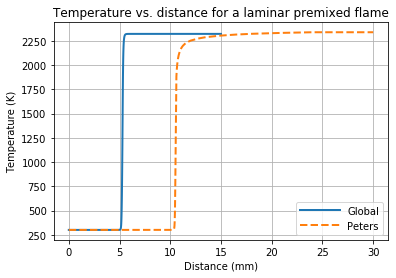

In [13]:
# plot the steady-state temperature profiles
fig, ax = plt.subplots()
ax.plot(flame1.grid*1000., flame1.T, label='Global', linestyle='-',  lw=2)
ax.plot(flame2.grid*1000., flame2.T, label='Peters', linestyle='--', lw=2)
ax.set(xlabel='Distance (mm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_x_LPF.pdf")

The burned-gas (equilibrium) temperatures are approximately the same for both mechanisms. This was discussed in tutorial Notebook 5_2_Global_reactions.

The flame is located closer to the unburned-gas (reactants) side for the global mechanism, compared to the more detailed mechanism. The flame location in the computational domain is somewhat arbitrary. To compare the flame structures, it is appropriate to shift the profiles so that they coincide at some point in the reaction zone. Here we do that by (somewhat arbitrarily) using the location in each flame where the temperature is 1000 K.

In [14]:
# specify the temperature at which to match the flame profiles
Tmatch = 1000. # (K)

# find the x location at which the temperature first exceeds a specified value
# there are more elegant and accurate ways to find the location at which the temperature is equal to a particular value,
#   but this is sufficient for present purposes

# flame 1 (two-step mechanism)
i = 0
T = 0.
while T < Tmatch:
    T = flame1.T[i]
    i += 1  
xmatch1 = flame1.grid[i-1]
print(xmatch1,flame1.T[i-1])

# flame 2 (more detailed mechanism)
i = 0
T = 0.
while T < Tmatch:
    T = flame2.T[i]
    i += 1    
xmatch2 = flame2.grid[i-1]
print(xmatch2,flame2.T[i-1])

0.0052734374999999995 1064.74316754693
0.010516845703125 1005.8633292897745


The two temperature values are not exactly the same and are not exactly equal to the prescribed value of Tmatch, but they are close enough for our purposes here. Interpolation could be used to get a more precise match, if needed.

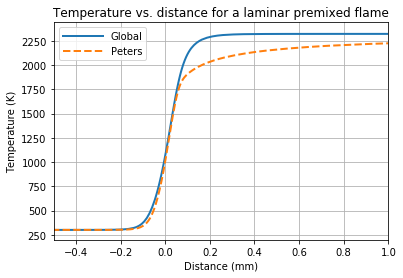

In [15]:
# plot the shifted steady-state temperature profiles, and zoom in
fig, ax = plt.subplots()
ax.plot((flame1.grid-xmatch1)*1000., flame1.T, label='Global', linestyle='-',  lw=2)
ax.plot((flame2.grid-xmatch2)*1000., flame2.T, label='Peters', linestyle='--', lw=2)
ax.set(xlim=(-0.5,1.0),
       xlabel='Distance (mm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_x_LPF_shift.pdf")

The two profiles intersect where the temperature is equal to 1000 K (approximately). The profiles then essentially overlap on the unburned-gas side, while the temperature reaches the equilibrium burned-gas value sooner for the global mechanism compared to the more detailed mechanism.

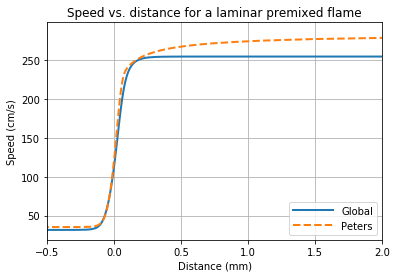

In [16]:
# plot the shifted steady-state velocity profiles, and zoom in
fig, ax = plt.subplots()
ax.plot((flame1.grid-xmatch1)*1000., flame1.u*100., label='Global', linestyle='-',  lw=2)
ax.plot((flame2.grid-xmatch2)*1000., flame2.u*100., label='Peters', linestyle='--', lw=2)
ax.set(xlim=(-0.5,2.0),
       xlabel='Distance (mm)',
       ylabel='Speed (cm/s)',
       title ='Speed vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("u_vs_x_LPF_shift.pdf")

The difference in laminar flame speed for the two mechanisms can be seen in the unburned gases. The difference in speeds is amplified in the burned gases. Recall that the product of density times speed (mass flux) must remain constant through each flame, although the mass flux needn't be (and isn't) the same for the two flames.

The unburned-gas and burned-gas densities are essentially the same for both flames, as can be verified as follows:

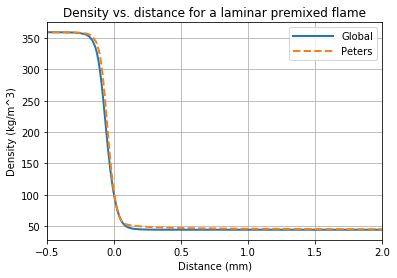

In [17]:
# plot the shifted density profiles, and zoom in
fig, ax = plt.subplots()
ax.plot((flame1.grid-xmatch1)*1000., flame1.density*100., label='Global', linestyle='-',  lw=2)
ax.plot((flame2.grid-xmatch2)*1000., flame2.density*100., label='Peters', linestyle='--', lw=2)
ax.set(xlim=(-0.5,2.0),
       xlabel='Distance (mm)',
       ylabel='Density (kg/m^3)',
       title ='Density vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("rho_vs_x_LPF_shift.pdf")

So, the higher burned-gas flow speed for the more detailed reaction mechanism is a consequence of the higher flame speed (and higher mass flux) for the detailed mechanism

Next, let's look at species-mole-fraction profiles.

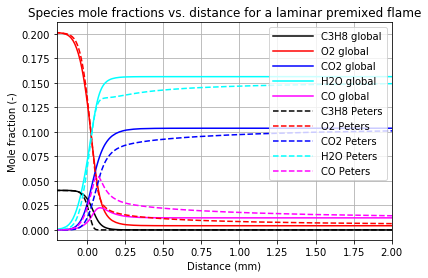

In [18]:
# plot the shifted steady-state species mole-fraction profiles, for the species that are common to both mechanisms
# skip N2 though, so that the other species profiles can be seen more clearly
fig, ax = plt.subplots()
ax.plot((flame1.grid-xmatch1)*1000., flame1.X[gas1.species_index('C3H8')], '-',  label='C3H8 global', color='black'  )
ax.plot((flame1.grid-xmatch1)*1000., flame1.X[gas1.species_index('O2')],   '-',  label='O2 global',   color='red'    )
ax.plot((flame1.grid-xmatch1)*1000., flame1.X[gas1.species_index('CO2')],  '-',  label='CO2 global',  color='blue'   )
ax.plot((flame1.grid-xmatch1)*1000., flame1.X[gas1.species_index('H2O')],  '-',  label='H2O global',  color='cyan'   )
ax.plot((flame1.grid-xmatch1)*1000., flame1.X[gas1.species_index('CO')],   '-',  label='CO global',   color='magenta')
ax.plot((flame2.grid-xmatch2)*1000., flame2.X[gas2.species_index('C3H8')], '--', label='C3H8 Peters', color='black'  )
ax.plot((flame2.grid-xmatch2)*1000., flame2.X[gas2.species_index('O2')],   '--', label='O2 Peters',   color='red'    )
ax.plot((flame2.grid-xmatch2)*1000., flame2.X[gas2.species_index('CO2')],  '--', label='CO2 Peters',  color='blue'   )
ax.plot((flame2.grid-xmatch2)*1000., flame2.X[gas2.species_index('H2O')],  '--', label='H2O Peters',  color='cyan'   )
ax.plot((flame2.grid-xmatch2)*1000., flame2.X[gas2.species_index('CO')],   '--', label='CO Peters',   color='magenta')
ax.set(xlim=(-0.2,2.0),
       xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("X_vs_x_LPF_shift.pdf")

The burned-gas mole fractions for all species are essentially the same for both mechanisms, but the final approach to equilibrium is much slower for the more detailed mechanism.

Finally, let's look at the heat-release-rate profiles. This shows where the conversion from chemical (formation) enthalpy to sensible enthalpy (heat) takes place, as we have seen before.

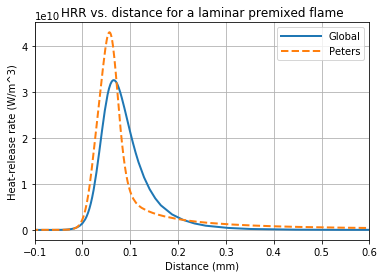

In [19]:
# plot the shifted steady-state heat-release-rate profiles, and zoom in
fig, ax = plt.subplots()
ax.plot((flame1.grid-xmatch1)*1000., flame1.heat_release_rate, label='Global', linestyle='-',  lw=2)
ax.plot((flame2.grid-xmatch2)*1000., flame2.heat_release_rate, label='Peters', linestyle='--', lw=2)
ax.set(xlim=(-0.1,0.6),
       xlabel='Distance (mm)',
       ylabel='Heat-release rate (W/m^3)',
       title ='HRR vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("HRR_vs_x_LPF_shift.pdf")

The spatial extent of the region over which most of the chemical activity takes place is approximately 0.1 mm for the more detailed mechanism. It is somewhat wider for the global mechanism. However, the profile for the more detailed mechanism has a longer "tail" that extends further into the burned-gas region. That is consistent with the slow approach of the species mole fractions to their equilibrium values that we saw in the previous figure. 

## 3. Parametric study: Laminar flame speed versus equivalence ratio

Here we will compute the laminar flame speed for C3H8-air reactant mixtures as a function of equivalence ratio, for a given reactant temperature and pressure, using the two reaction mechanisms. The reactant temperature and pressure are 300 K and 3 atm, respectively, corresponding to the conditions for which a figure is shown at https://www.cerfacs.fr/cantera/mechanisms/prop.php.

In [20]:
# define a function that returns the laminar flame speed for a given reactant mixture state
# here we suppress all output - this can be dangerous, if one is not confident that the solution will converge for all
#   cases of interest
# gas is the gas mixture for which the flame speed is to be computed - note that we pass it as an argument to the
#   function here, it contrast to the approach that was used in earlier tutorial Notebooks
# T_u is the unburned gas temperature (K)
# P is the pressure (Pa)
# fuel is the fuel desired, which must be available in "gas"
# air is the mixture of species corresponding to air, which must be defined before calling this function
# phi is the desired equivalence ratio
def gas_sl(gas,T_u,P,fuel,air,phi):
    gas.TP = T_u, P
    gas.set_equivalence_ratio(phi,fuel,air)
    width = 0.015 # (m)
    flame = ct.FreeFlame(gas, width=width)
    flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
    loglevel = 0
    flame.solve(loglevel=loglevel, auto=True)
    s_l = flame.u[0] # (m/s)
    return s_l

In [21]:
# specify the reactants fuel, air, temperature, and pressure
fuel  = 'C3H8'
air   = 'O2:1.0, N2:3.76'
T_u   = 300.
P     = 3.*ct.one_atm

# specify the values of the equivalence ratio at which to compute the laminar flame speed
phis = [0.70, 0.80, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70, 1.80]

In [22]:
# define an array to hold the computed laminar flame speed for each equivalence ratio for the global mechanism
S_Lgas1 = np.zeros(np.size(phis))

# loop over the equivalence ratios, and compute the laminar flame speed for each equivalence ratio
for i, phi in enumerate(phis):
    S_Lgas1[i] = gas_sl(gas1,T_u,P,fuel,air,phi)
    print(i,phi,S_Lgas1[i])

0 0.7 0.18165544181071488
1 0.8 0.2341422129849063
2 0.9 0.2804178633703852
3 0.95 0.29965008065190013
4 1.0 0.31436871388338333
5 1.05 0.3230793452537273
6 1.1 0.3295823279430281
7 1.15 0.3336502351825937
8 1.2 0.33625238769466476
9 1.3 0.33754296179986837
10 1.4 0.33545487538281493
11 1.5 0.3322441272543218
12 1.6 0.32648916255181093
13 1.7 0.3201619605013484
14 1.8 0.31315396988743954


In [23]:
# define an array to hold the computed laminar flame speed for each equivalence ratio for the more detailed mechanism
S_Lgas2 = np.zeros(np.size(phis))

# loop over the equivalence ratios, and compute the laminar flame speed for each equivalence ratio
# this will require significantly more computational time, compared to the global mechanism
for i, phi in enumerate(phis):
    S_Lgas2[i] = gas_sl(gas2,T_u,P,fuel,air,phi)
    print(i,phi,S_Lgas2[i])

0 0.7 0.16746563113110194
1 0.8 0.24039848180488135
2 0.9 0.30445501556958365
3 0.95 0.33073887564909277
4 1.0 0.35069608852135714
5 1.05 0.36265698448551675
6 1.1 0.36495419607916835
7 1.15 0.35426725358806227
8 1.2 0.32765911538636305
9 1.3 0.21472611727020052
10 1.4 0.11170659383018253
11 1.5 0.07781352399326805
12 1.6 0.05714467009261705
13 1.7 0.04295424816262462
14 1.8 0.032041090677059986


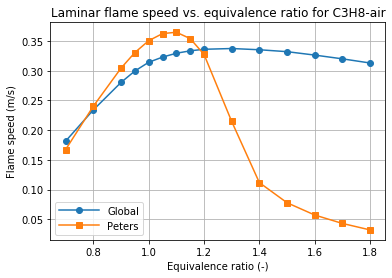

In [24]:
# plot laminar flame speeds versus equivalence ratio
fig, ax = plt.subplots()
ax.plot(phis , S_Lgas1, '-o', label='Global')
ax.plot(phis , S_Lgas2, '-s', label='Peters')
ax.set(xlabel='Equivalence ratio (-)',
       ylabel='Flame speed (m/s)',
       title ='Laminar flame speed vs. equivalence ratio for C3H8-air')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("SL_vs_phi.pdf")

Assuming that the results from the more detailed mechanism are more accurate (which is indeed the case here), it can be seen that this global mechanism is intended to be used for fuel-lean-to-stoichiometric reactant mixtures. Presumably, it should be possible to change the values of the rate coefficients in the global mechanism to realize better agreement for fuel-rich reactants.

## 4. What's next

In the next tutorial Notebook, we will look at the influence of changing the molecular transport model, for the same reaction mechanism.